In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


> **Importing Libs**

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler 
from sklearn.impute import SimpleImputer
import math

> **Loading files**

In [3]:
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
display(df_train.head(2))
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
display(df_test.head(2))
print(df_train.shape)
print(df_test.shape)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers


(8693, 14)
(4277, 13)


> **EDA**

In [4]:
for x in ['Cabin','HomePlanet','Destination','CryoSleep','Transported']:
    print(df_train[x].value_counts())
    print('-'*40)

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64
----------------------------------------
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
----------------------------------------
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
----------------------------------------
False    5439
True     3037
Name: CryoSleep, dtype: int64
----------------------------------------
True     4378
False    4315
Name: Transported, dtype: int64
----------------------------------------


In [5]:
df_train[["Deck", "Cabin_num", "Side"]] = df_train["Cabin"].str.split("/", expand=True)
df_test[["Deck", "Cabin_num", "Side"]] = df_test["Cabin"].str.split("/", expand=True)

for x in ['Deck','Cabin_num','Side']:
    print(df_train[x].value_counts())
    print('-'*40)

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64
----------------------------------------
82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: Cabin_num, Length: 1817, dtype: int64
----------------------------------------
S    4288
P    4206
Name: Side, dtype: int64
----------------------------------------


In [6]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_num       199
Side            199
dtype: int64

In [7]:
df_train.groupby(['HomePlanet','Destination']).agg({'PassengerId':np.size})

PassengerId
HomePlanet Destination               
Earth      55 Cancri e            690
           PSO J318.5-22          712
           TRAPPIST-1e           3101
Europa     55 Cancri e            886
           PSO J318.5-22           19
           TRAPPIST-1e           1189
Mars       55 Cancri e            193
           PSO J318.5-22           49
           TRAPPIST-1e           1475

In [8]:
df_train['HomePlanet'].fillna('Earth',inplace=True)
df_test['HomePlanet'].fillna('Earth',inplace=True)
df_train.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_num       199
Side            199
dtype: int64

In [9]:
df_train['Destination'].fillna('TRAPPIST-1e',inplace=True)
df_test['Destination'].fillna('TRAPPIST-1e',inplace=True)
df_train.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_num       199
Side            199
dtype: int64

In [10]:
print(type(df_train['CryoSleep'][0]))
df_train.dtypes

<class 'bool'>


PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Deck             object
Cabin_num        object
Side             object
dtype: object

In [11]:
df_train.groupby(['HomePlanet','Destination','CryoSleep']).agg({'PassengerId':np.size})

PassengerId
HomePlanet Destination   CryoSleep             
Earth      55 Cancri e   False              485
                         True               222
           PSO J318.5-22 False              348
                         True               363
           TRAPPIST-1e   False             2397
                         True               872
Europa     55 Cancri e   False              420
                         True               441
           PSO J318.5-22 False               10
                         True                 9
           TRAPPIST-1e   False              732
                         True               461
Mars       55 Cancri e   False              112
                         True                76
           PSO J318.5-22 False               36
                         True                11
           TRAPPIST-1e   False              899
                         True               582

In [12]:
ind_tr = df_train[(df_train['HomePlanet']=='Earth') & (df_train['Destination']=='PSO J318.5-22')].index
ind_te = df_test[(df_test['HomePlanet']=='Earth') & (df_test['Destination']=='PSO J318.5-22')].index
for x in ind_tr:
    if(df_train['CryoSleep'][x] is np.nan):
        df_train['CryoSleep'][x] = True

for x in ind_te:
    if(df_test['CryoSleep'][x] is np.nan):
        df_test['CryoSleep'][x] = True
print(df_train.isna().sum())
print('-'*40)
print(df_test.isna().sum())

PassengerId       0
HomePlanet        0
CryoSleep       200
Cabin           199
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_num       199
Side            199
dtype: int64
----------------------------------------
PassengerId       0
HomePlanet        0
CryoSleep        86
Cabin           100
Destination       0
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Deck            100
Cabin_num       100
Side            100
dtype: int64


/tmp/ipykernel_33/250748385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['CryoSleep'][x] = True
/tmp/ipykernel_33/250748385.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CryoSleep'][x] = True


In [13]:
ind1_tr = df_train[(df_train['HomePlanet']=='Europa') & (df_train['Destination']=='55 Cancri e')].index
ind1_te = df_test[(df_test['HomePlanet']=='Europa') & (df_test['Destination']=='55 Cancri e')].index
for x in ind1_tr:
    if(df_train['CryoSleep'][x] is np.nan):
        df_train['CryoSleep'][x] = True
        
for x in ind1_te:
    if(df_test['CryoSleep'][x] is np.nan):
        df_test['CryoSleep'][x] = True
print(df_train.isna().sum())
print('-'*40)
print(df_test.isna().sum())

PassengerId       0
HomePlanet        0
CryoSleep       175
Cabin           199
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_num       199
Side            199
dtype: int64
----------------------------------------
PassengerId       0
HomePlanet        0
CryoSleep        79
Cabin           100
Destination       0
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Deck            100
Cabin_num       100
Side            100
dtype: int64


/tmp/ipykernel_33/4031542434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['CryoSleep'][x] = True
/tmp/ipykernel_33/4031542434.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CryoSleep'][x] = True


In [14]:
df_train['CryoSleep'].fillna(False,inplace=True)
df_test['CryoSleep'].fillna(False,inplace=True)
print(df_train.isna().sum())
print('-'*40)
print(df_test.isna().sum())

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_num       199
Side            199
dtype: int64
----------------------------------------
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Deck            100
Cabin_num       100
Side            100
dtype: int64


In [15]:
df_train.groupby(['HomePlanet','Destination','Transported']).agg({'PassengerId':np.size})

PassengerId
HomePlanet Destination   Transported             
Earth      55 Cancri e   False                352
                         True                 369
           PSO J318.5-22 False                363
                         True                 365
           TRAPPIST-1e   False               2034
                         True                1320
Europa     55 Cancri e   False                275
                         True                 611
           PSO J318.5-22 False                  5
                         True                  14
           TRAPPIST-1e   False                447
                         True                 779
Mars       55 Cancri e   False                 75
                         True                 118
           PSO J318.5-22 False                 27
                         True                  22
           TRAPPIST-1e   False                737
                         True                 780

In [16]:
df_train.groupby(['HomePlanet','Destination','CryoSleep','Transported']).agg({'PassengerId':np.size})

PassengerId
HomePlanet Destination   CryoSleep Transported             
Earth      55 Cancri e   False     False                303
                                   True                 196
                         True      False                 49
                                   True                 173
           PSO J318.5-22 False     False                236
                                   True                 112
                         True      False                127
                                   True                 253
           TRAPPIST-1e   False     False               1716
                                   True                 766
                         True      False                318
                                   True                 554
Europa     55 Cancri e   False     False                263
                                   True                 157
                         True      False                 12
                                   True                 454
           PSO J318.5-22 False     False                  5
                                   True                   5
                         True      True                   9
           TRAPPIST-1e   False     False                439
                                   True                 326
                         True      False                  8
                                   True                 453
Mars       55 Cancri e   False     False                 73
                                   True                  44
                         True      False                  2
                                   True                  74
           PSO J318.5-22 False     False                 26
                                   True                  12
                         True      False                  1
                                   True                  10
           TRAPPIST-1e   False     False                681
                                   True                 254
                         True      False                 56
                                   True                 526

In [17]:
df_train.groupby(['CryoSleep','Transported']).agg({'PassengerId':np.size})

PassengerId
CryoSleep Transported             
False     False               3742
          True                1872
True      False                573
          True                2506

> **Features Management**

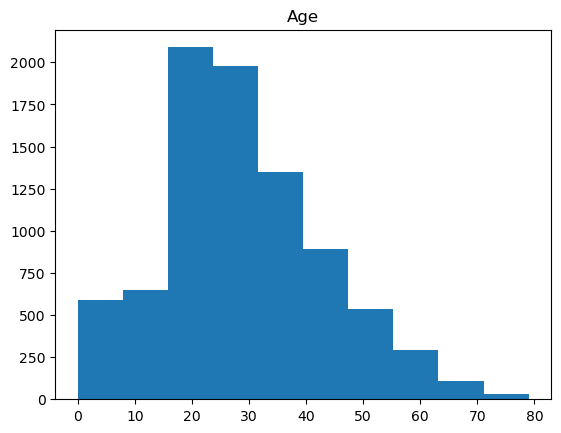

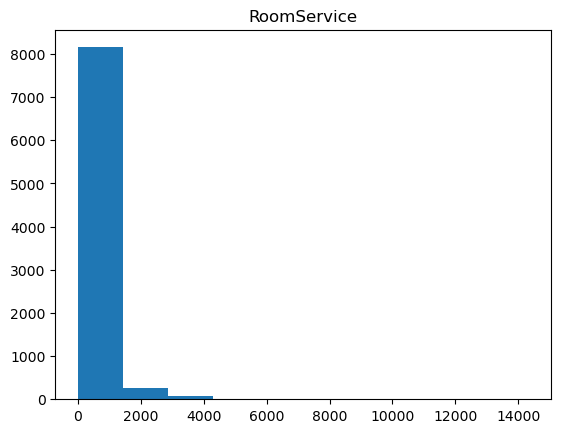

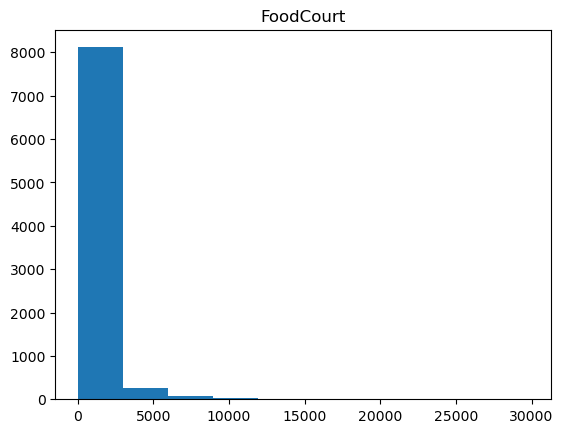

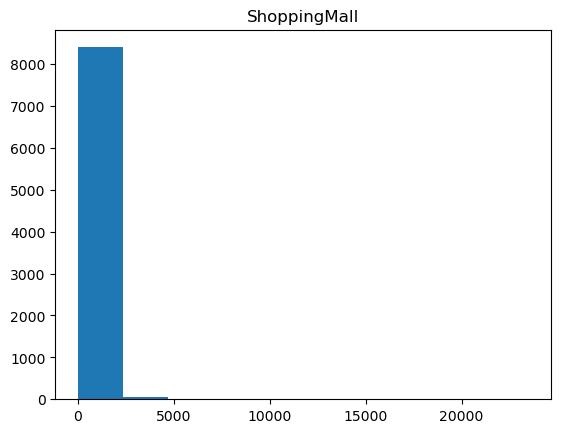

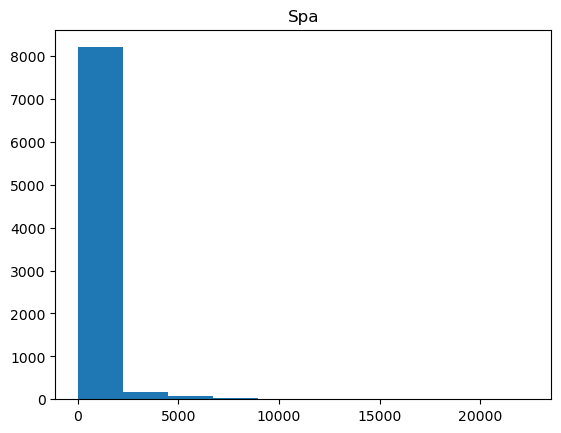

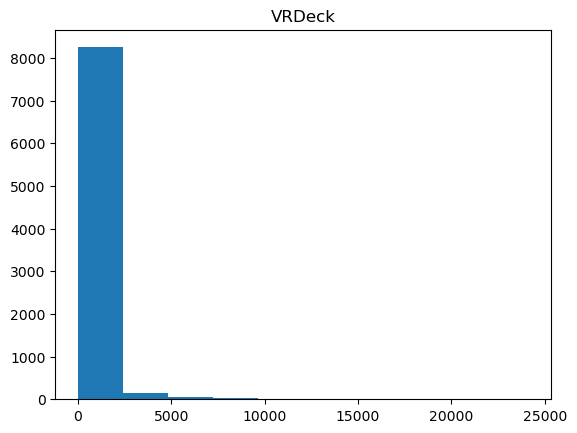

In [18]:
num_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cat_features = ['HomePlanet','CryoSleep','Deck','Side','Destination','VIP']

#Cabin_num feature omitted from here for now

for x in num_features:
    plt.hist(df_train[x])
    plt.title(x)
    #sns.distplot(df_train[x])
    plt.show()

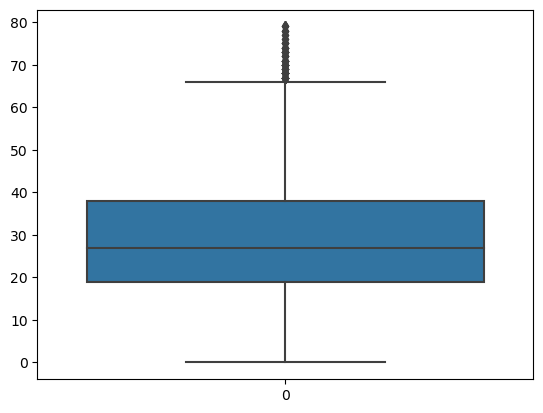

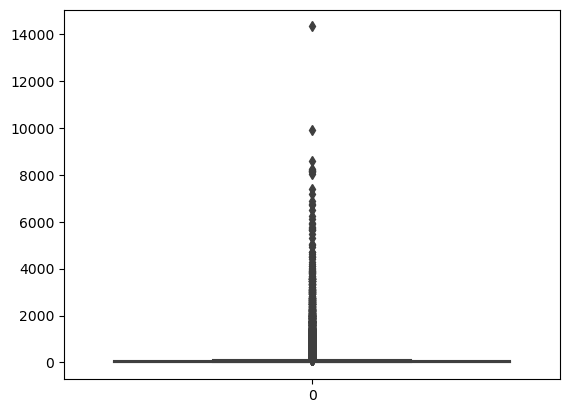

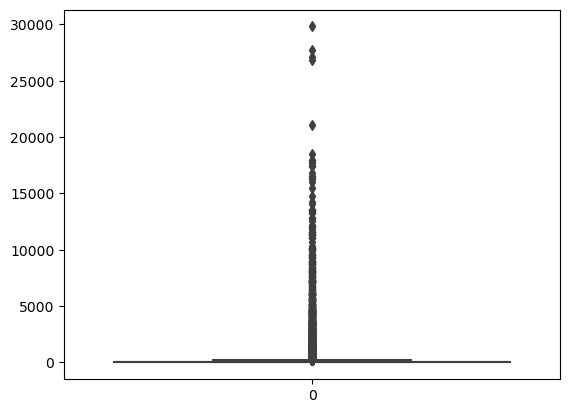

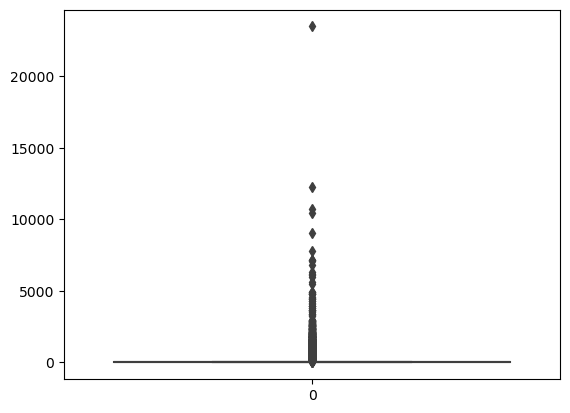

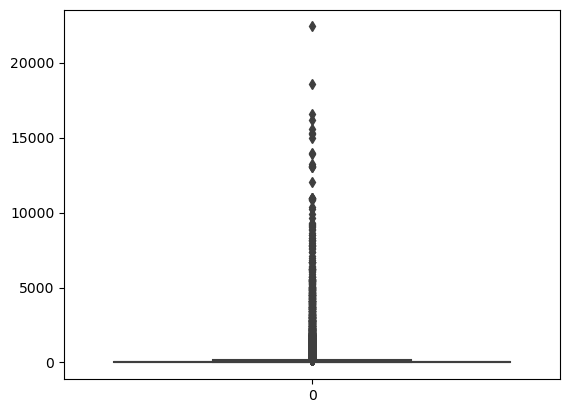

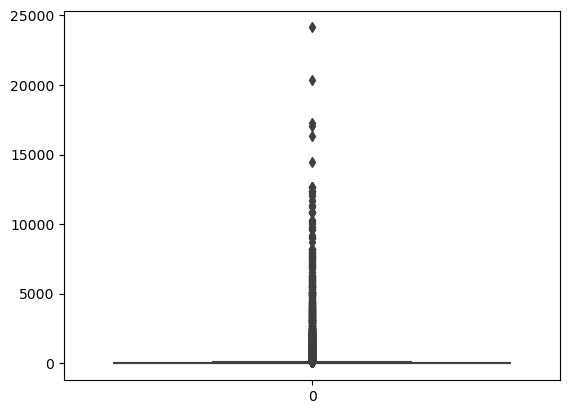

In [19]:
for x in num_features:
    sns.boxplot(df_train[x])
    plt.show()

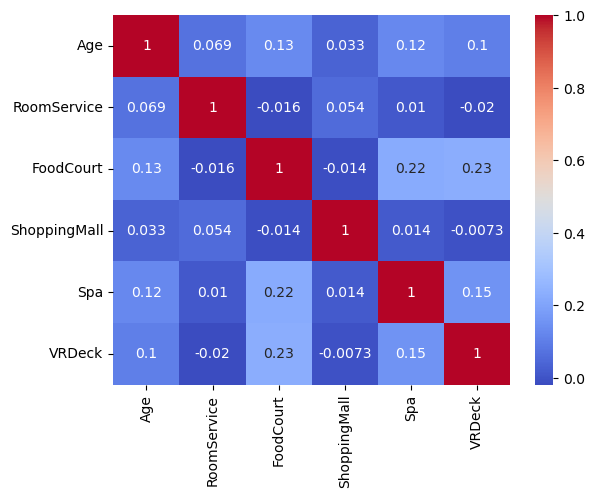

In [20]:
sns.heatmap(df_train[num_features].corr(), annot=True, cmap='coolwarm')
plt.show()

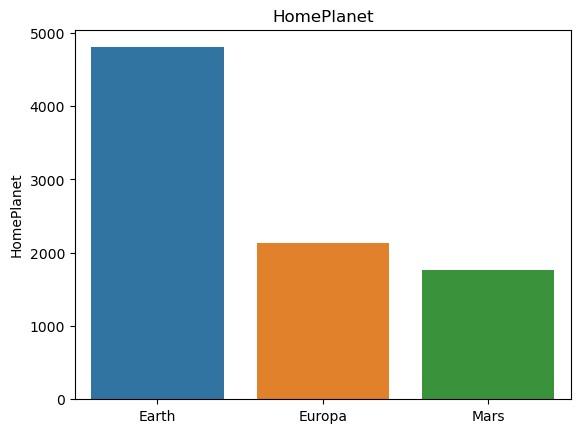

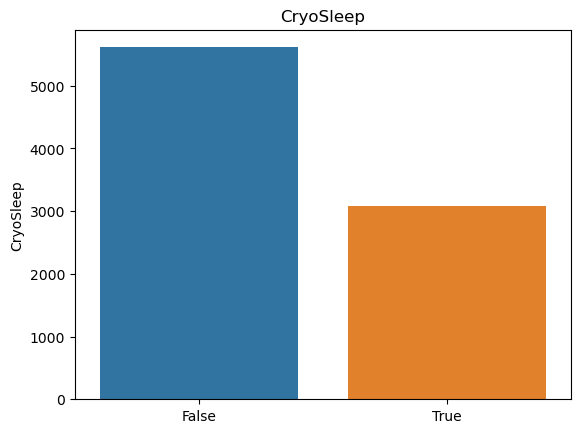

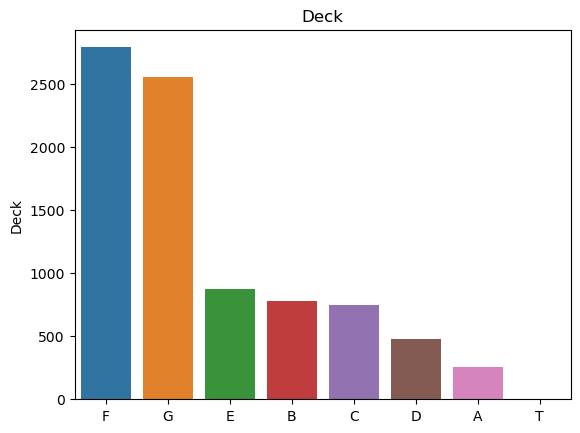

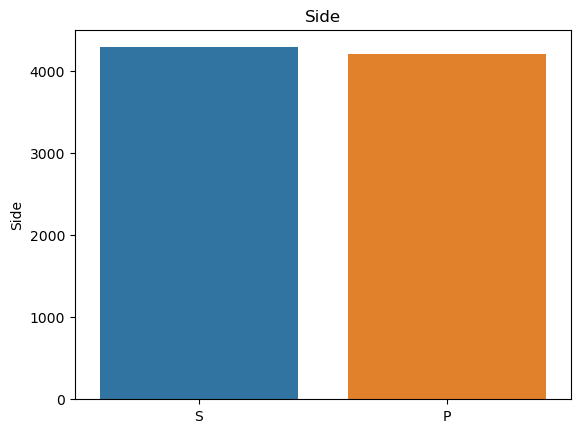

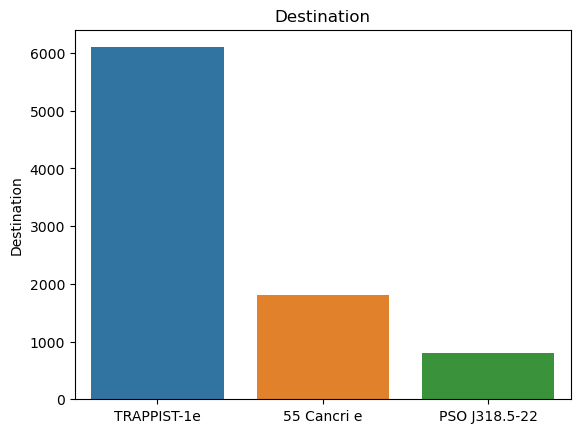

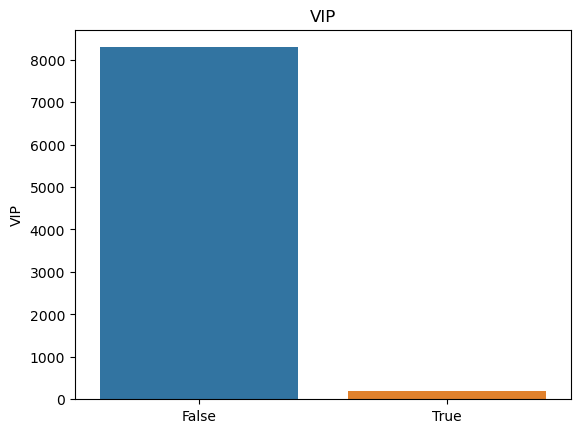

In [21]:
for x in cat_features:
    sns.barplot(x=df_train[x].value_counts().index, y=df_train[x].value_counts()).set_title(x)
#    sns.countplot(df_train[x])
    plt.show()

In [22]:
display(pd.pivot_table(df_train, index='Transported', columns='Deck', values='PassengerId', aggfunc='count'))
display(pd.pivot_table(df_train, index='Transported', columns='Side', values='PassengerId', aggfunc='count'))
display(pd.pivot_table(df_train, index='Transported', columns='CryoSleep', values='PassengerId', aggfunc='count'))
display(pd.pivot_table(df_train, index='Transported', columns='HomePlanet', values='PassengerId', aggfunc='count'))
display(pd.pivot_table(df_train, index='Transported', columns='Destination', values='PassengerId', aggfunc='count'))
display(pd.pivot_table(df_train, index='Transported', columns='VIP', values='PassengerId', aggfunc='count'))

Deck,A,B,C,D,E,F,G,T
Transported,,,,,,,,
False,129,207,239,271,563,1565,1238,4
True,127,572,508,207,313,1229,1321,1


Side,P,S
Transported,,
False,2308,1908
True,1898,2380


CryoSleep,False,True
Transported,,
False,3742,573
True,1872,2506


HomePlanet,Earth,Europa,Mars
Transported,,,
False,2749,727,839
True,2054,1404,920


Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
Transported,,,
False,702,395,3218
True,1098,401,2879


VIP,False,True
Transported,,
False,4093,123
True,4198,76


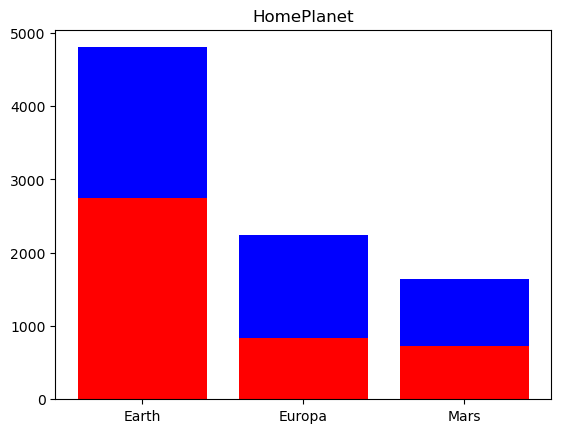

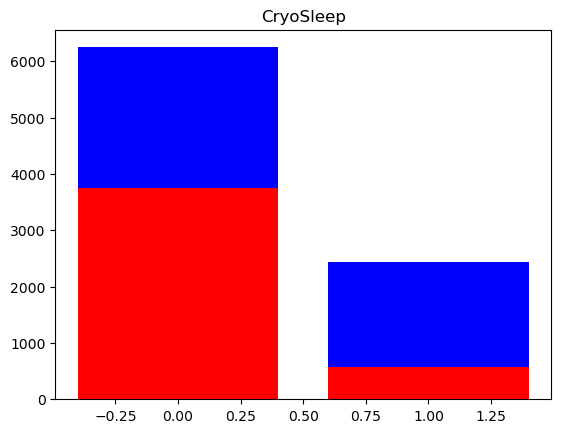

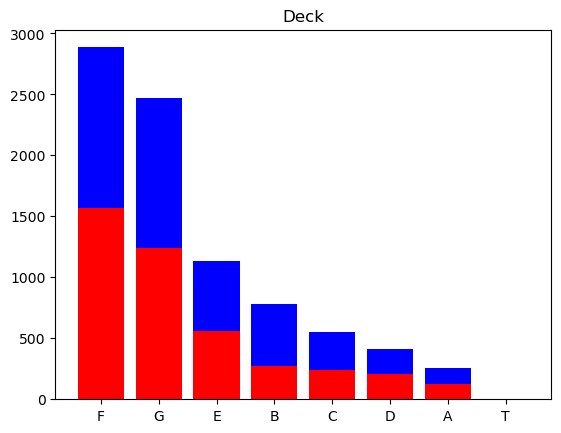

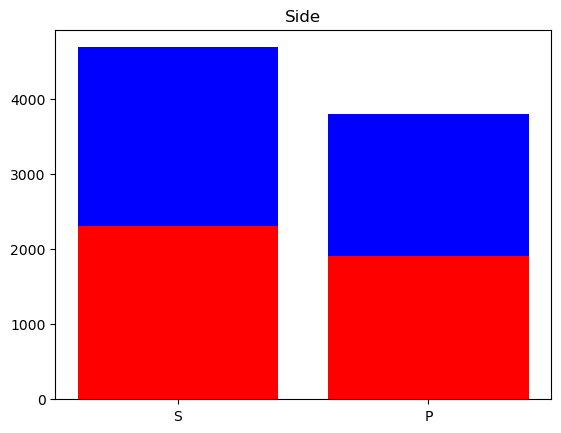

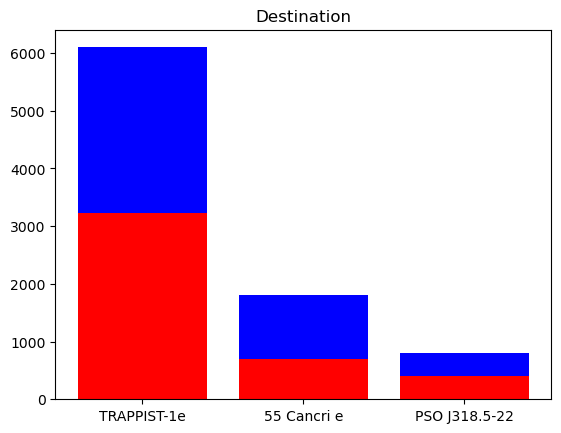

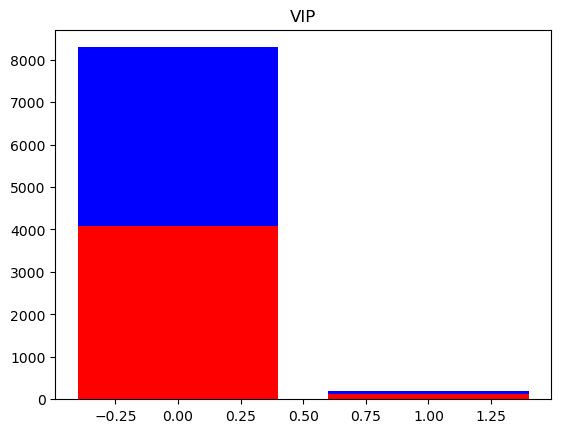

In [23]:
pos = df_train['Transported']==True
neg = df_train['Transported']==False

for x in cat_features:
    #sns.barplot(x=df_train[x].value_counts().index, y=df_train[x].value_counts()).set_title(x)
    plt.bar(df_train[x].value_counts().index, df_train[neg][x].value_counts(), color='r')
    plt.bar(df_train[x].value_counts().index, df_train[pos][x].value_counts(), 
            bottom=df_train[neg][x].value_counts(), color='b')
    plt.title(x)
    plt.show()

# Red => Transported == False, Blue => Transported == True

In [24]:
df_train.groupby(['HomePlanet','Destination','CryoSleep','VIP']).agg({'PassengerId':np.size})

PassengerId
HomePlanet Destination   CryoSleep VIP               
Earth      55 Cancri e   False     False          483
                                   True             1
                         True      False          213
                                   True             1
           PSO J318.5-22 False     False          337
                         True      False          371
           TRAPPIST-1e   False     False         2427
                                   True             3
                         True      False          849
Europa     55 Cancri e   False     False          365
                                   True            49
                         True      False          442
                                   True            14
           PSO J318.5-22 False     True            10
                         True      False            9
           TRAPPIST-1e   False     False          699
                                   True            49
                         True      False          443
                                   True             9
Mars       55 Cancri e   False     False          115
                         True      False           74
           PSO J318.5-22 False     False           29
                                   True             8
                         True      False           10
           TRAPPIST-1e   False     False          858
                                   True            55
                         True      False          567

In [25]:
temp_tr = df_train[(df_train['HomePlanet']=='Europa')].index
temp_te = df_test[(df_test['HomePlanet']=='Europa')].index

for x in temp_tr:
    if(df_train['VIP'][x] is np.nan):
        df_train['VIP'] = True
        
for x in temp_te:
    if(df_test['VIP'][x] is np.nan):
        df_test['VIP'] = True

In [26]:
temp_tr = df_train[(df_train['HomePlanet']=='Mars') & (df_train['Destination']=='PSO J318.5-22')
                  & (df_train['CryoSleep']==False)].index
temp_te = df_test[(df_test['HomePlanet']=='Mars') & (df_test['Destination']=='PSO J318.5-22')
                  & (df_test['CryoSleep']==False)].index

for x in temp_tr:
    if(df_train['VIP'][x] is np.nan):
        df_train['VIP'] = True
        
for x in temp_te:
    if(df_test['VIP'][x] is np.nan):
        df_test['VIP'] = True

In [27]:
temp_tr = df_train[(df_train['HomePlanet']=='Mars') & (df_train['Destination']=='TRAPPIST-1e')
                  & (df_train['CryoSleep']==False)].index
temp_te = df_test[(df_test['HomePlanet']=='Mars') & (df_test['Destination']=='TRAPPIST-1e')
                  & (df_test['CryoSleep']==False)].index

for x in temp_tr:
    if(df_train['VIP'][x] is np.nan):
        df_train['VIP'] = True
        
for x in temp_te:
    if(df_test['VIP'][x] is np.nan):
        df_test['VIP'] = True

In [28]:
df_train['VIP'].fillna(False, inplace=True)
df_test['VIP'].fillna(False, inplace=True)
print(df_train.isna().sum())
print(df_test.isna().sum())

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_num       199
Side            199
dtype: int64
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age              91
VIP               0
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Deck            100
Cabin_num       100
Side            100
dtype: int64


In [29]:
df_train.groupby(['CryoSleep','VIP','Deck']).agg({'PassengerId':np.size})

PassengerId
CryoSleep VIP  Deck             
False     True A             186
               B             352
               C             443
               D             374
               E             704
               F            2235
               G            1201
               T               5
True      True A              70
               B             427
               C             304
               D             104
               E             172
               F             559
               G            1358

In [30]:
df_train.groupby(['CryoSleep','VIP','Side']).agg({'PassengerId':np.size})

PassengerId
CryoSleep VIP  Side             
False     True P            2765
               S            2735
True      True P            1441
               S            1553

> **Missing Value Treatment**

In [31]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for temp in ['Deck','Side']:
    df_train[[temp]] = imp.fit_transform(df_train[[temp]])
    df_test[[temp]] = imp.fit_transform(df_test[[temp]])
display(df_train.isna().sum())
print('-'*40)
display(df_test.isna().sum())

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck              0
Cabin_num       199
Side              0
dtype: int64

----------------------------------------


PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age              91
VIP               0
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Deck              0
Cabin_num       100
Side              0
dtype: int64

In [32]:
df_train['Age'].fillna(df_train['Age'].median(),inplace=True)
df_test['Age'].fillna(df_test['Age'].median(),inplace=True)

In [33]:
for temp in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
    df_train[temp].fillna(df_train[temp].mean(),inplace=True)
    df_test[temp].fillna(df_test[temp].mean(),inplace=True)
display(df_train.isna().sum())
print('-'*40)
display(df_test.isna().sum())

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
Deck              0
Cabin_num       199
Side              0
dtype: int64

----------------------------------------


PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name             94
Deck              0
Cabin_num       100
Side              0
dtype: int64

In [34]:
df_train.drop(['PassengerId','Cabin','Name','Cabin_num'],axis=1,inplace=True)
df_test.drop(['PassengerId','Cabin','Name','Cabin_num'],axis=1,inplace=True)

> **Data Processing**

In [35]:
label = LabelEncoder()
for temp in ['CryoSleep','VIP','Side']:
    df_train[temp] = label.fit_transform(df_train[temp])
    df_test[temp] = label.fit_transform(df_test[temp])
df_train['Transported'] = label.fit_transform(df_train['Transported'])
df_train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,1


In [36]:
df_train = pd.get_dummies(data = df_train, columns = ['HomePlanet','Destination','Deck'])
df_test = pd.get_dummies(data = df_test, columns = ['HomePlanet','Destination','Deck'])
df_train.head(2)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,...,0,1,0,0,0,0,0,1,0,0


In [37]:
#temp_1 = df_train.copy()
#temp_2 = df_test.copy()

In [38]:
#df_train = temp_1.copy()
#df_test = temp_2.copy()

In [37]:
"""
for temp in num_features:
    df_train[temp] = (df_train[temp] - df_train[temp].mean())/df_train[temp].std()
    df_test[temp] = (df_test[temp] - df_test[temp].mean())/df_test[temp].std()
df_train['Age'] = (df_train['Age'] - df_train['Age'].mean())/df_train['Age'].std()
for x in num_features:
"""

for x in list(set(num_features) - {'Age'}):
    df_train[x] = np.log10(df_train[x] + 1)
    df_test[x] = np.log10(df_test[x] + 1)
df_train['Age'] = (df_train['Age'] - df_train['Age'].mean())/df_train['Age'].std()
df_test['Age'] = (df_test['Age'] - df_test['Age'].mean())/df_test['Age'].std()
df_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,0.711904,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0,-0.334018,0,2.041393,1.000000,1.414973,2.740363,1.653213,1,1,...,0,1,0,0,0,0,0,1,0,0
2,0,2.036740,0,1.643453,3.553519,0.000000,3.827111,1.698970,0,1,...,0,1,1,0,0,0,0,0,0,0
3,0,0.293535,0,0.000000,3.108565,2.570543,3.522444,2.287802,0,1,...,0,1,1,0,0,0,0,0,0,0
4,0,-0.891844,0,2.482874,1.851258,2.181844,2.752816,0.477121,1,1,...,0,1,0,0,0,0,0,1,0,0


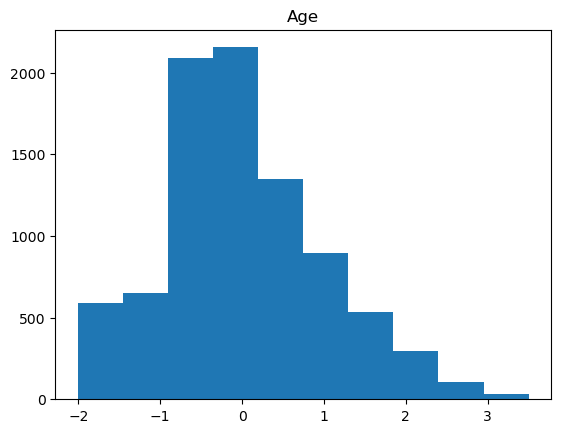

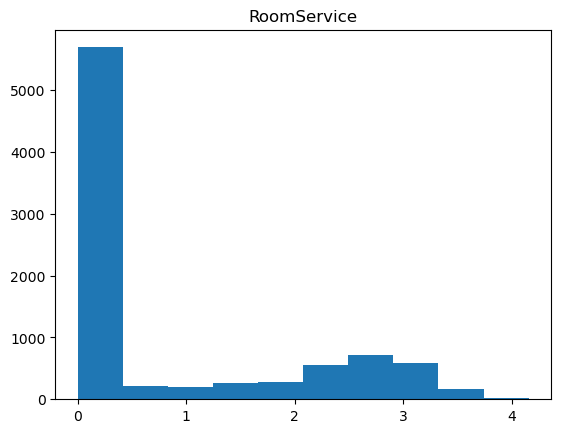

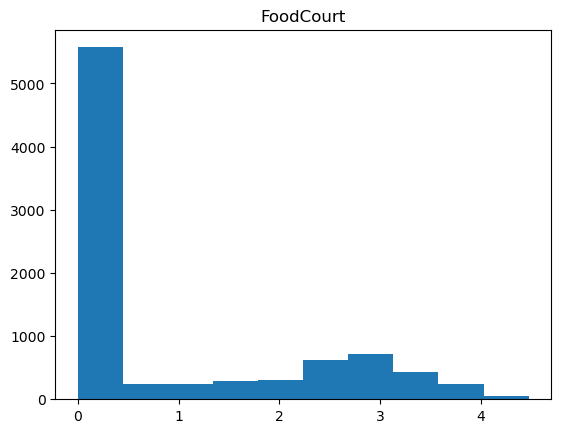

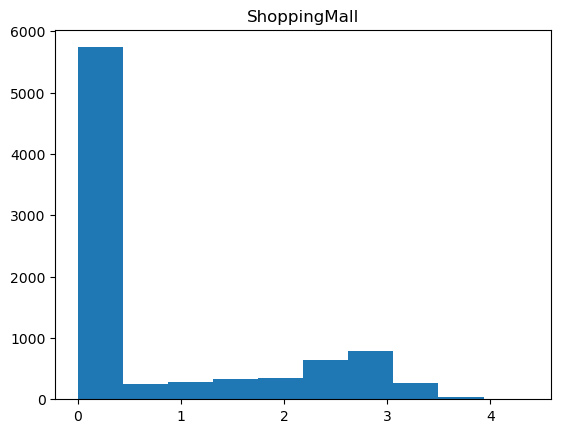

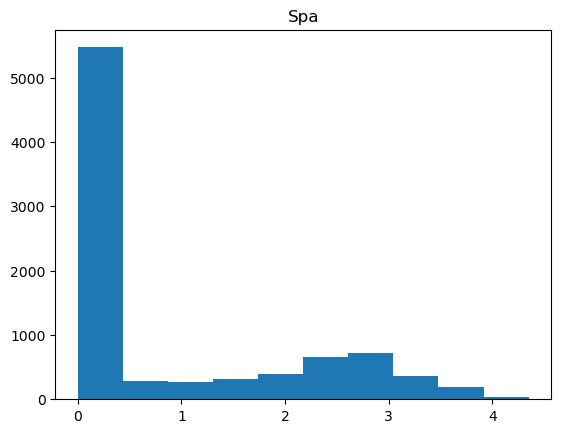

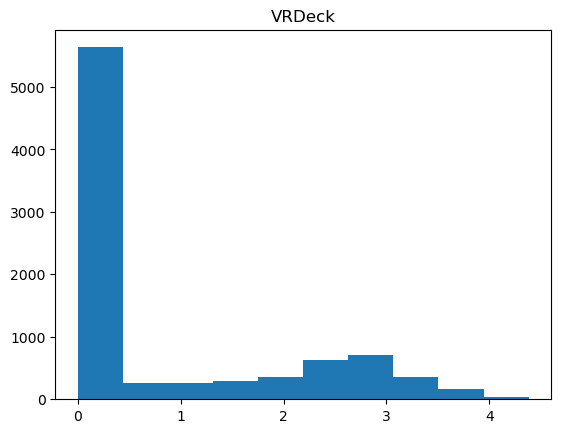

In [38]:
for x in num_features:
    plt.hist(df_train[x])
    plt.title(x)
    plt.show()

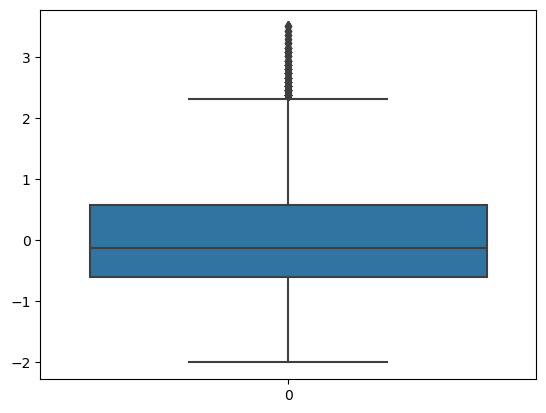

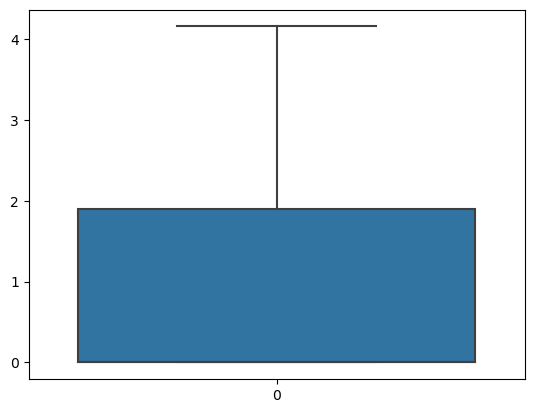

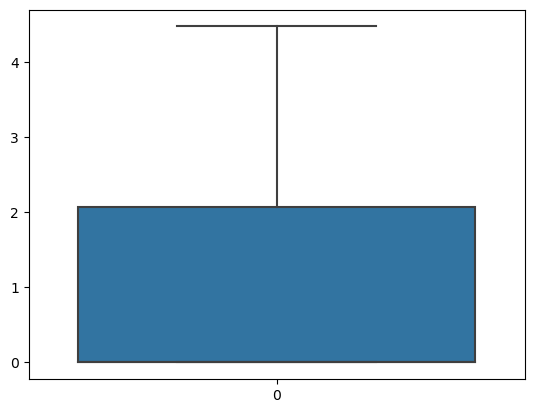

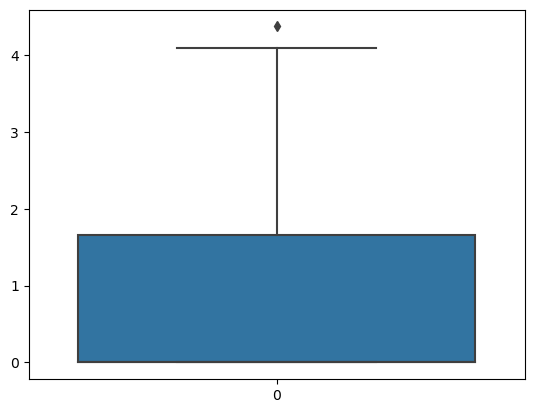

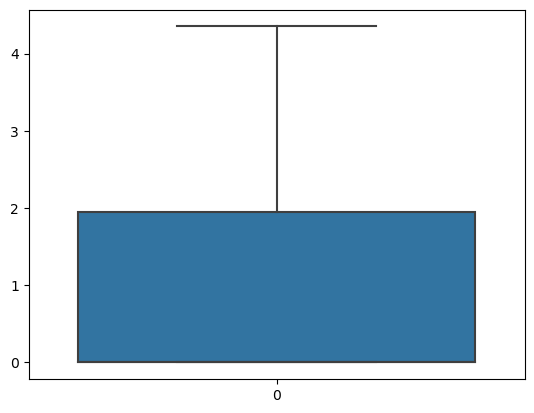

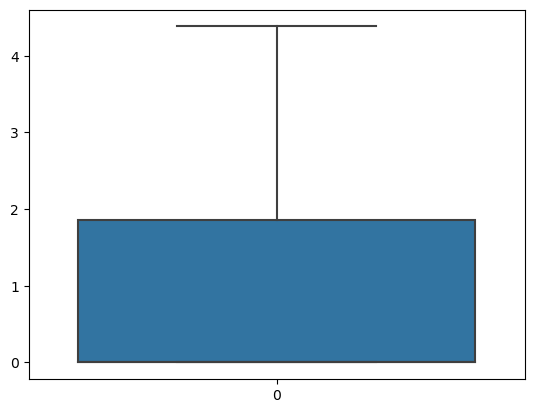

In [39]:
for x in num_features:
    sns.boxplot(df_train[x])
    plt.show()

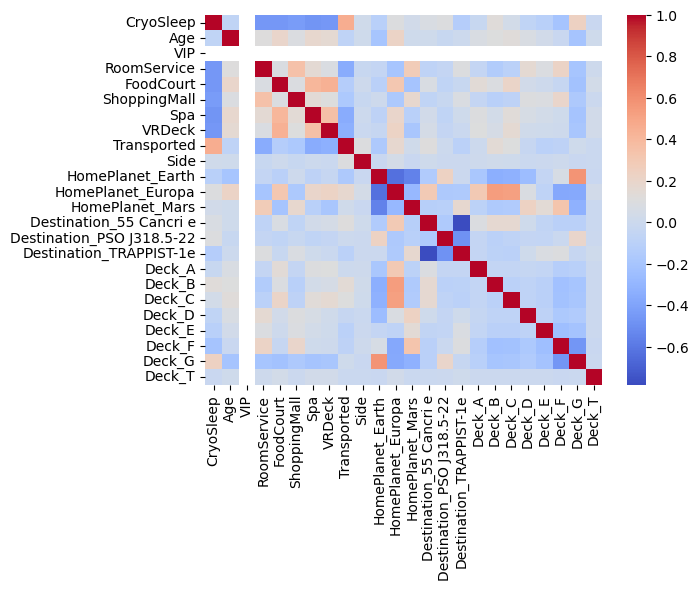

In [40]:
sns.heatmap(df_train.corr(), cmap='coolwarm')
plt.show()

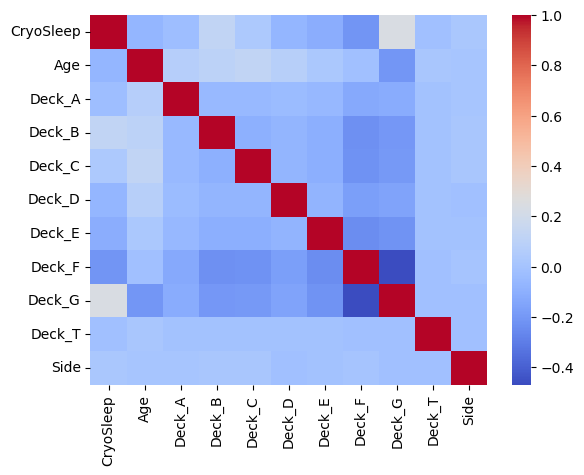

In [41]:
trial = ['CryoSleep','Age','Deck_A','Deck_B','Deck_C','Deck_D','Deck_E','Deck_F','Deck_G','Deck_T','Side']
sns.heatmap(df_train[trial].corr(), cmap='coolwarm')
plt.show()

> **Logistic Regression using sklearn**

In [42]:
x_train = df_train.copy()
x_train = x_train.reindex(np.random.permutation(x_train.index))
y_train = x_train.pop('Transported')
x_test = df_test.copy()
x_test = x_test.reindex(np.random.permutation(x_test.index))

"""
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_pred = np.zeros(x_test.shape[0])
"""

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
#print(y_pred.shape)

(8693, 23)
(4277, 23)
(8693,)


In [77]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [44]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold,train_test_split,RandomizedSearchCV, GridSearchCV


In [45]:
def training_perf(model, x_train, y_train):
    model = model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    
    print('Predicted Values: ',y_pred)
    print('-'*50)
    print('Accuracy Score: ',accuracy_score(y_pred,y_train)*100)
    print('-'*50)
    print(classification_report(y_pred, y_train))

In [46]:
models = [['Naive Bayes',GaussianNB()],['Logistic',LogisticRegression(max_iter=200)],['Decision Tree',DecisionTreeClassifier()],
         ['KNN',KNeighborsClassifier()],['Random Forest',RandomForestClassifier()],['SVM',SVC(probability=True)],
          ['XGB',XGBClassifier()]]

In [47]:
for x in models:
    print(x[0],':\n')
    training_perf(x[1],x_train,y_train)
    print('*'*50)

Naive Bayes :

Predicted Values:  [1 1 0 ... 0 1 1]
--------------------------------------------------
Accuracy Score:  74.74979868860002
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      4464
           1       0.73      0.76      0.74      4229

    accuracy                           0.75      8693
   macro avg       0.75      0.75      0.75      8693
weighted avg       0.75      0.75      0.75      8693

**************************************************
Logistic :

Predicted Values:  [1 1 0 ... 0 1 1]
--------------------------------------------------
Accuracy Score:  77.94777407109169
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      4292
           1       0.78      0.78      0.78      4401

    accuracy                           0.78      8693
   macro avg       0.78      

In [48]:
def cross(model,x_train,y_train):
    skfold = StratifiedKFold(n_splits=10)
    results = cross_val_score(model,x_train,y_train,cv=skfold,scoring='f1')
    print('Individual Results: ',results, '\n\n Mean: ', results.mean(), '\n\n Standard Deviation: ',results.std())

In [49]:
for x in models:
    print(x[0],':\n')
    cross(x[1],x_train,y_train)
    print('*'*50)

Naive Bayes :

Individual Results:  [0.74500588 0.74730539 0.74219653 0.69949917 0.73903002 0.75514874
 0.74560375 0.75420875 0.71981243 0.75382803] 

 Mean:  0.7401638691626371 

 Standard Deviation:  0.0166906257940156
**************************************************
Logistic :

Individual Results:  [0.79452055 0.78911565 0.75489068 0.76869965 0.76958002 0.77828054
 0.78977933 0.78941566 0.77097506 0.80229885] 

 Mean:  0.7807555983246093 

 Standard Deviation:  0.013859720190311517
**************************************************
Decision Tree :

Individual Results:  [0.74943052 0.74305556 0.73265074 0.72624434 0.76339286 0.73492605
 0.75395034 0.74690664 0.74182638 0.72494172] 

 Mean:  0.7417325153589028 

 Standard Deviation:  0.011648417980835336
**************************************************
KNN :

Individual Results:  [0.74091442 0.757259   0.73573923 0.75886525 0.77625571 0.79439252
 0.76905041 0.78004535 0.75296912 0.79249707] 

 Mean:  0.7657988083973593 

 Standard

In [50]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size = 0.2, random_state=42)

In [51]:
votc = VotingClassifier(estimators = [(x,y) for (x,y) in models], voting = 'soft')
training_perf(votc,x_train,y_train)

Predicted Values:  [1 1 1 ... 1 0 1]
--------------------------------------------------
Accuracy Score:  90.83980442910556
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      3131
           1       0.96      0.87      0.91      3823

    accuracy                           0.91      6954
   macro avg       0.91      0.91      0.91      6954
weighted avg       0.91      0.91      0.91      6954



In [52]:
cross(votc,x_train,y_train)

Individual Results:  [0.80216802 0.81450488 0.78762307 0.80769231 0.80501393 0.8125
 0.80504909 0.81147541 0.7826087  0.82417582] 

 Mean:  0.8052811222526804 

 Standard Deviation:  0.011721967442045797


In [53]:
def best(model,x_train,x_valid,y_train,y_valid,params):
    grid = GridSearchCV(model,param_grid=params,scoring='f1',n_jobs=-1,cv=10)
    grid = grid.fit(x_train,y_train)
    
    print('Best Parameters: ',grid.best_params_)
    print('\n Best Estimator: ',grid.best_estimator_)
    print('\n Best f1 score: ',grid.best_score_)

    best_model = grid.best_estimator_
    best_models_1.append(best_model)
    best_model = best_model.fit(x_train, y_train)
    y_pred = best_model.predict(x_valid)
    print('\n','Validation Set Accuracy: %f'%(accuracy_score(y_pred,y_valid) * 100))
    print('\n',classification_report(y_valid, y_pred))

In [78]:
params = [
    ['Logistic',LogisticRegression(max_iter=200),{'max_iter': [2000],'C': np.logspace(-4,4,20)}],
    ['KNN',KNeighborsClassifier(),{'n_neighbors': [3,5,7,9],'weights':['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree'],'p':[1,2]}]
]

In [ ]:
"""
Possibilities for svm
{'kernel':['rbf'],'gamma':[.1,.5,1,2,5,10],'C':[.1,1,10,100,1000]}
{'kernel':['linear'],'C':[.1,1,10,100,1000]}
{'kernel':['poly'],'degree':[2,3,4,5],'C':[.1,1,10,100,1000]}
"""

In [79]:
best_models_1 = []

for x in params:
    print(x[0],':\n')
    best(x[1],x_train,x_valid,y_train,y_valid,x[2])
    print('*'*50)

Logistic :

Best Parameters:  {'C': 0.08858667904100823, 'max_iter': 2000}

 Best Estimator:  LogisticRegression(C=0.08858667904100823, max_iter=2000)

 Best f1 score:  0.7808466238533157

 Validation Set Accuracy: 77.285796

               precision    recall  f1-score   support

           0       0.76      0.77      0.77       849
           1       0.78      0.77      0.78       890

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739

**************************************************
KNN :

Best Parameters:  {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

 Best Estimator:  KNeighborsClassifier(n_neighbors=9, p=1)

 Best f1 score:  0.777564435639903

 Validation Set Accuracy: 76.825762

               precision    recall  f1-score   support

           0       0.74      0.81      0.77       849
           1       0.80      0.73      0.76       890

 

In [80]:
best_models_1

[LogisticRegression(C=0.08858667904100823, max_iter=2000),
 KNeighborsClassifier(n_neighbors=9, p=1)]

In [93]:
rf_params = {
            'criterion':['entropy','gini'],
            'bootstrap':[True,False],
            'max_depth':[3,5,10,20,50,75,100,None],
            'min_samples_leaf':[1,2,4,10],
            'min_samples_split':[2,5,10]
}

In [ ]:
"""
Possibility for rf:
'n_estimators':[100,500,1000],
'max_features':['auto','sqrt']
"""

In [84]:
xgb_params = {
    'n_estimators':[20,50,100,250,500,1000],
    'colsample_bytree':[0.2,0.5,0.7,0.8,1],
    'max_depth':[2,5,10,15,20,25,None],
    'reg_alpha':[0,0.5,1],
    'reg_lambda':[1,1.5,2],
    'learning_rate':[0.01,0.03,0.1,0.3,1,3,10],
    'subsample':[0.5,0.6,0.7,0.8,0.9],
    'gamma':[0,0.01,0.1,1,10,100],
    'min_child_weight':[0,0.01,0.1,1,10,100],
    'sampling_method':['uniform','gradient_based']
}

In [85]:
def random(model,x_train,x_valid,y_train,y_valid,params):
    rand = RandomizedSearchCV(model,param_distributions=params,scoring='f1',n_iter=100,n_jobs=-1,cv=10,verbose=True)
    rand = rand.fit(x_train,y_train)
    
    print('Best Parameters: ',rand.best_params_)
    print('\n Best Estimator: ',rand.best_estimator_)
    print('\n Best f1 score: ',rand.best_score_)

    best_model = rand.best_estimator_
    best_models_2.append(best_model)
    best_model = best_model.fit(x_train, y_train)
    y_pred = best_model.predict(x_valid)
    print('\n','Validation Set Accuracy: %f'%(accuracy_score(y_pred,y_valid) * 100))
    print('\n',classification_report(y_valid, y_pred))

In [94]:
best_models_2 = []

for x in [['Random Forest',RandomForestClassifier(random_state=1),rf_params],
         ['XGB',XGBClassifier(random_state=1),xgb_params]]:
    print(x[0],':\n')
    random(x[1],x_train,x_valid,y_train,y_valid,x[2])
    print('*'*50)

Random Forest :

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters:  {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}

 Best Estimator:  RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                       min_samples_split=10, random_state=1)

 Best f1 score:  0.8059078469674986

 Validation Set Accuracy: 79.585969

               precision    recall  f1-score   support

           0       0.80      0.78      0.79       849
           1       0.79      0.81      0.80       890

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

**************************************************
XGB :

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters:  {'subsample': 0.6, 'sampling_method': 'uniform', 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_

In [95]:
best_models_2

[RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                        min_samples_split=10, random_state=1),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=0.01, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=1, ...)]

> **After finding the best models, now create following Voting Classifiers:**
> 1) KNN, SVC, RF (Soft/Hard) || 
> 2) KNN, RF, LR, SVC (Soft) || 
> 3) KNN, SVC, RF, LR, XGB (Soft)

In [96]:
votc_1 = VotingClassifier(estimators = [('KNN',best_models_1[1]),('SVC',SVC(probability=True)),
                                       ('Random Forest',best_models_2[0])], voting = 'soft')
training_perf(votc_1,x_train,y_train)
cross(votc_1,x_train,y_train)

Predicted Values:  [1 0 1 ... 1 0 1]
--------------------------------------------------
Accuracy Score:  82.5136612021858
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3408
           1       0.83      0.82      0.83      3546

    accuracy                           0.83      6954
   macro avg       0.83      0.83      0.83      6954
weighted avg       0.83      0.83      0.83      6954

Individual Results:  [0.81276006 0.82102273 0.77410072 0.8220339  0.80863309 0.8057971
 0.8        0.81241185 0.77793494 0.82402235] 

 Mean:  0.80587167258475 

 Standard Deviation:  0.016560208053659518


In [97]:
votc_2 = VotingClassifier(estimators = [('KNN',best_models_1[1]),('SVC',SVC(probability=True)),
                                       ('Random Forest',best_models_2[0])], voting = 'hard')
training_perf(votc_2,x_train,y_train)
cross(votc_2,x_train,y_train)

Predicted Values:  [1 0 1 ... 1 0 1]
--------------------------------------------------
Accuracy Score:  82.48490077653149
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3388
           1       0.84      0.82      0.83      3566

    accuracy                           0.82      6954
   macro avg       0.82      0.83      0.82      6954
weighted avg       0.83      0.82      0.82      6954

Individual Results:  [0.80939227 0.82051282 0.78571429 0.82072829 0.80397727 0.80918221
 0.8005698  0.81523272 0.78762307 0.83146067] 

 Mean:  0.8084393407908477 

 Standard Deviation:  0.013805665834537104


In [98]:
votc_3 = VotingClassifier(estimators = [('KNN',best_models_1[1]),('SVC',SVC(probability=True)),
                                       ('Random Forest',best_models_2[0]),('Logistic',best_models_1[0])], voting = 'soft')
training_perf(votc_3,x_train,y_train)
cross(votc_3,x_train,y_train)

Predicted Values:  [1 0 1 ... 1 0 1]
--------------------------------------------------
Accuracy Score:  81.7946505608283
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3404
           1       0.83      0.81      0.82      3550

    accuracy                           0.82      6954
   macro avg       0.82      0.82      0.82      6954
weighted avg       0.82      0.82      0.82      6954

Individual Results:  [0.80945758 0.82571429 0.77809798 0.81741573 0.81597718 0.81205165
 0.8028777  0.8028169  0.77446809 0.81792717] 

 Mean:  0.8056804259349277 

 Standard Deviation:  0.016127599198194533


In [99]:
votc_4 = VotingClassifier(estimators = [('KNN',best_models_1[1]),('SVC',SVC(probability=True)),
                                       ('Random Forest',best_models_2[0]),('Logistic',best_models_1[0]),
                                       ('XGB',best_models_2[1])], voting = 'soft')
training_perf(votc_4,x_train,y_train)
cross(votc_4,x_train,y_train)

Predicted Values:  [1 0 1 ... 1 0 1]
--------------------------------------------------
Accuracy Score:  82.32671843543284
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3391
           1       0.83      0.82      0.83      3563

    accuracy                           0.82      6954
   macro avg       0.82      0.82      0.82      6954
weighted avg       0.82      0.82      0.82      6954

Individual Results:  [0.81163435 0.82285714 0.77985612 0.82187938 0.81934566 0.81088825
 0.80400572 0.8079096  0.77746479 0.82402235] 

 Mean:  0.8079863365566192 

 Standard Deviation:  0.016002499851634856


In [49]:
"""
feat_imp = pd.Series(model.feature_importances_, index = x_train.columns)
feat_imp.nlargest(20).plot(kind='barh')
plt.show()
"""

"\nfeat_imp = pd.Series(model.feature_importances_, index = x_train.columns)\nfeat_imp.nlargest(20).plot(kind='barh')\nplt.show()\n"

In [51]:
"""
from sklearn.ensemble import VotingClassifier
votc = VotingClassifier(estimators = list of tuples:(name, model), voting = 'hard'/'soft')
cv = cross_val_score(votc, x_train, y_train)
"""

"\nfrom sklearn.ensemble import VotingClassifier\nvotc = VotingClassifier(estimators = list of tuples:(name, model), voting = 'hard'/'soft')\ncv = cross_val_score(votc, x_train, y_train)\n"

In [100]:
y1_submit = votc_1.predict(x_test)
y2_submit = votc_2.predict(x_test)
y3_submit = votc_3.predict(x_test)
y4_submit = votc_4.predict(x_test)

In [101]:
submit_1 = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submit_1.drop(['HomePlanet','CryoSleep','Cabin','Destination','Age','VIP','RoomService','FoodCourt',
             'ShoppingMall','Spa','VRDeck','Name'],axis =1,inplace=True)

submit_2 = submit_1.copy()
submit_3 = submit_1.copy()
submit_4 = submit_1.copy()

submit_1['Transported'] = y1_submit.copy()
submit_2['Transported'] = y2_submit.copy()
submit_3['Transported'] = y3_submit.copy()
submit_4['Transported'] = y4_submit.copy()

submit_1['Transported'] = submit_1['Transported'].map({0:'FALSE',1:'TRUE'})
submit_2['Transported'] = submit_2['Transported'].map({0:'FALSE',1:'TRUE'})
submit_3['Transported'] = submit_3['Transported'].map({0:'FALSE',1:'TRUE'})
submit_4['Transported'] = submit_4['Transported'].map({0:'FALSE',1:'TRUE'})

In [102]:
display(submit_1.head())
display(submit_2.head())
display(submit_3.head())
display(submit_4.head())

,PassengerId,Transported
0,0013_01,TRUE
1,0018_01,FALSE
2,0019_01,TRUE
3,0021_01,TRUE
4,0023_01,TRUE


,PassengerId,Transported
0,0013_01,TRUE
1,0018_01,FALSE
2,0019_01,TRUE
3,0021_01,TRUE
4,0023_01,TRUE


,PassengerId,Transported
0,0013_01,TRUE
1,0018_01,FALSE
2,0019_01,TRUE
3,0021_01,TRUE
4,0023_01,TRUE


,PassengerId,Transported
0,0013_01,TRUE
1,0018_01,FALSE
2,0019_01,TRUE
3,0021_01,TRUE
4,0023_01,TRUE


In [103]:
submit_1.to_csv('submission_1.csv',index=False)
submit_2.to_csv('submission_2.csv',index=False)
submit_3.to_csv('submission_3.csv',index=False)
submit_4.to_csv('submission_4.csv',index=False)

> **Using tensorflow ensemble models**